In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import networkx as nx
import community as community_louvain
from collections import Counter, defaultdict
import netwulf as nw
import numpy as np
from Netwulf_plot_functions import netwulf_plot_communities
from community import community_louvain 
import pickle

# Focusing on artists from the US - Modularity 

In [23]:
nodes_df = pd.read_csv('nodes.csv')
edges_df = pd.read_csv('edges.csv')
nodes_df['genres'] = nodes_df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
artists_us_df = pd.read_csv("most_listened_artists_in_US_dataset.csv", index_col=0)
artists_us_name_list = (artists_us_df.index).tolist()
nodes_df = nodes_df[nodes_df["name"].isin(artists_us_name_list)]
duplicate_names = nodes_df[nodes_df.duplicated(subset="name", keep=False)].sort_values(by="name")
final_cleaned_nodes_df = nodes_df.sort_values("followers", ascending=False)
final_cleaned_nodes_df = nodes_df.drop_duplicates(subset="name", keep="first")

In [4]:
def split_artists_by_genre(nodes_df, genre_names, exclusive=False):    
    nodes_df = nodes_df.copy()

    filtered_dfs = []

    for genre in genre_names:
        if exclusive:
            other_genres = [g for g in genre_names if g != genre]
            
            df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres) and all(other not in ' '.join(genres) for other in other_genres)
                )
            ].copy()
        else:
             df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres)
                )
            ].copy()
        
        filtered_dfs.append(df)

    return filtered_dfs

def get_Graph_with_names(nodes_df, edges_df, verbose=True):
    nodes_df = nodes_df.dropna(subset=['spotify_id', 'name'])
    edges_df = edges_df.dropna(subset=['id_0', 'id_1'])

    # Build ID to name map
    id_to_name = dict(zip(nodes_df['spotify_id'], nodes_df['name']))
    allowed_ids = set(id_to_name.keys())

    # Create graph with artist names as nodes
    G = nx.Graph()

    for _, row in nodes_df.iterrows():
        artist_name = row['name']
        followers = row['followers'] if not pd.isna(row['followers']) else 0
        popularity = row['popularity'] if not pd.isna(row['popularity']) else 0
        genres = row['genres']
        chart_hits = row['chart_hits'] if not pd.isna(row['chart_hits']) else []

        G.add_node(artist_name, followers=followers, popularity=popularity,
                   genres=genres, chart_hits=chart_hits)

    for _, row in edges_df.iterrows():
        id_0, id_1 = row['id_0'], row['id_1']
        if id_0 in allowed_ids and id_1 in allowed_ids:
            name_0 = id_to_name.get(id_0)
            name_1 = id_to_name.get(id_1)
            if name_0 and name_1:
                G.add_edge(name_0, name_1)

    if verbose:
        print(f"Number of nodes: {G.number_of_nodes()}")
        print(f"Number of edges: {G.number_of_edges()}")
        print(f"Network density: {nx.density(G)}")

    return G

def get_n_largest_component(G, n):
    return sorted(nx.connected_components(G), key=len, reverse=True)[n]

def apply_louvain(G, verbose=True):
    partition = community_louvain.best_partition(G)

    nx.set_node_attributes(G, partition, 'community')
    
    if verbose:
        community_sizes = Counter(partition.values())
        sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)
        for community_id, size in sorted_communities:
            print(f"Community {community_id}: {size} nodes")
    
    communities = defaultdict(list)
    for node, community_id in partition.items():
        communities[community_id].append(node)
    
    sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)
    return sorted_communities
        
def get_community_subgraph(G, community_id):
    nodes_in_community = [n for n, attr in G.nodes(data=True) if attr.get('community') == community_id]
    
    subgraph = G.subgraph(nodes_in_community).copy()
    
    return subgraph

def get_combined_louvain_splitted_graph(G):
    _G = G.copy()
    partition = community_louvain.best_partition(_G)
    nx.set_node_attributes(_G, partition, 'community')

    combined_G = nx.Graph()
    
    combined_G.add_nodes_from(_G.nodes(data=True))

    for u, v in _G.edges():
        if partition[u] == partition[v]:
            combined_G.add_edge(u, v, **_G[u][v])

    return combined_G

def print_top_collaborators(G, n):
    top_collaborators = sorted(G.degree, key=lambda x: x[1], reverse=True)[:n]

    print(f"Top {n} artists with the most collaborations:")
    for rank, (artist, degree) in enumerate(top_collaborators, start=1):
        print(f"{rank}. {artist} — {degree} collaborations")


In [5]:
df_tes = pd.read_csv("most_listened_artists_in_US_dataset.csv")
df_us = df_tes[df_tes["Country"] == "US"]
df_us = df_us.rename(columns={"Name": "name"})
us_names = df_us["name"].tolist()

In [6]:
final_df = final_cleaned_nodes_df[final_cleaned_nodes_df["name"].isin(us_names)]

In [7]:
final_df

,spotify_id,name,followers,popularity,genres,chart_hits
15,3xs0LEzcPXtgNfMNcHzLIP,Rockwell,40344.0,58,[],"['us (1)', 'gb (1)', 'at (1)', 'be (1)', 'ca (..."
54,0LyOADBjj28cbvJWTXUEGA,Loren Allred,111839.0,58,"[deep talent show, hollywood, movie tunes]","['us (1)', 'gb (2)', 'au (2)', 'at (1)', 'cz (..."
85,7wU2WGCJ8HxkekHHE2QLul,Fuego,253571.0,67,"[latin hip hop, rap dominicano, reggaeton, reg...","['ar (3)', 'bo (2)', 'cl (2)', 'co (3)', 'cr (..."
88,2l35CQqtYRh3d8ZIiBep4v,MKTO,995449.0,66,"[dance pop, pop, pop rap, pop rock, post-teen ...","['us (3)', 'gb (2)', 'au (5)', 'at (1)', 'be (..."
152,7h1amg0X7Q5d0D5KfuyKTg,Pyrex,29130.0,57,"[italian hip hop, trap italiana]",['it (3)']
...,...,...,...,...,...,...
154021,5oFkj1qSlyBUmV5d6Edgtq,Cozz,175894.0,54,[underground hip hop],NaN
154404,5YCU9eHY4IYTyNa8XRFuw9,Alex Hosking,3743.0,48,[],NaN
155001,3nQ59hkeciYoR6RreQL4Rv,Darren Criss,117746.0,52,[],NaN
155024,79QO0Xmn1dZhvaLicS2Yrs,The Night Game,37079.0,44,"[indie poptimism, modern alternative rock]",NaN


In [8]:
pop_df, rap_df = split_artists_by_genre(final_df, ["pop", "rap"])

print(len(pop_df), len(rap_df))
G_pop = get_Graph_with_names(pop_df, edges_df)
G_rap = get_Graph_with_names(rap_df, edges_df)

535 319
Number of nodes: 535
Number of edges: 1983
Network density: 0.01388217998529875
Number of nodes: 319
Number of edges: 2138
Network density: 0.04215216576960233


In [9]:
communities = apply_louvain(G_rap)
largest_community_id = communities[0][0]

G_largest_rap_community = get_community_subgraph(G_rap, largest_community_id)
G_largest_rap_community_splitted = get_combined_louvain_splitted_graph(G_largest_rap_community)

Community 4: 79 nodes
Community 31: 64 nodes
Community 17: 40 nodes
Community 8: 35 nodes
Community 16: 31 nodes
Community 7: 17 nodes
Community 3: 4 nodes
Community 23: 2 nodes
Community 1: 1 nodes
Community 2: 1 nodes
Community 9: 1 nodes
Community 11: 1 nodes
Community 14: 1 nodes
Community 15: 1 nodes
Community 19: 1 nodes
Community 20: 1 nodes
Community 21: 1 nodes
Community 22: 1 nodes
Community 26: 1 nodes
Community 28: 1 nodes
Community 29: 1 nodes
Community 30: 1 nodes
Community 32: 1 nodes
Community 33: 1 nodes
Community 34: 1 nodes
Community 35: 1 nodes
Community 37: 1 nodes
Community 38: 1 nodes
Community 39: 1 nodes
Community 40: 1 nodes
Community 41: 1 nodes
Community 42: 1 nodes
Community 43: 1 nodes
Community 44: 1 nodes
Community 45: 1 nodes
Community 46: 1 nodes
Community 48: 1 nodes
Community 49: 1 nodes
Community 50: 1 nodes
Community 51: 1 nodes
Community 52: 1 nodes
Community 53: 1 nodes
Community 10: 1 nodes
Community 12: 1 nodes
Community 13: 1 nodes
Community 4

## Modularity and using our double edge swap

In [10]:
import random as rnd
from tqdm import tqdm
from multiprocessing import get_context

In [11]:
for graph in [G_pop, G_rap]: 
    communities = community_louvain.best_partition(graph)
    modularity = community_louvain.modularity(communities, graph)
    print("Modularity: ", modularity)

Modularity:  0.31716425216966515
Modularity:  0.280116861705991


In [13]:
def double_egde_swap(original_G): 
    G2 = original_G.copy()
    edges = set(G2.edges())

    for i in range(len(edges)*10): 
        swap_successful = False
        while not swap_successful: 
            e1,e2 = rnd.sample(list(edges), 2)
            if e1[0] != e2[1] and e1[1] != e2[0] and e1[0] != e2[0] and e1[1] != e2[1]: 
                old_e1 = e1
                if rnd.random() >0.5: 
                    e1 = (e1[1], e1[0])
                
                e11 = (e1[0], e2[1])
                e22 = (e2[0], e1[1])
                if (e11 not in G2.edges()) and (e22 not in G2.edges()) and ( e11[0] != e11[1] or e22[0] != e22[1]): 
                    #update egdes set
                    edges.remove(old_e1)
                    edges.remove(e2)
                    edges.add(e11)
                    edges.add(e22)

                    #Remove old egdes and Add new egdes
                    G2.remove_edges_from([old_e1,e2])
                    G2.add_edges_from([e11,e22])
        
                    swap_successful = True

    return G2

def parallel(G):
    p = get_context("fork").Pool(8)
    results = p.map(double_egde_swap, [G for _ in range(8)])
    p.close()
    return results

### POP

In [ ]:
rnd_networks = []
for i in range(126): 
    rnd_networks += parallel(G_pop)
    print(i)

with open("1000random_networks.pkl", "wb") as f: 
   pickle.dump(rnd_networks, f)
mods = []

for g in rnd_networks: 
    communities = community_louvain.best_partition(g)
    modularity = community_louvain.modularity(communities, g)
    mods.append(modularity)

Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Process ForkPoolWorker-3:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocess

KeyboardInterrupt: 

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Version

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^

In [130]:
mean = np.mean(mods)
std = np.std(mods)
print(f"Mean: {mean}, Std: {std}")

Mean: 0.24021598945457703, Std: 0.0037669989093365762


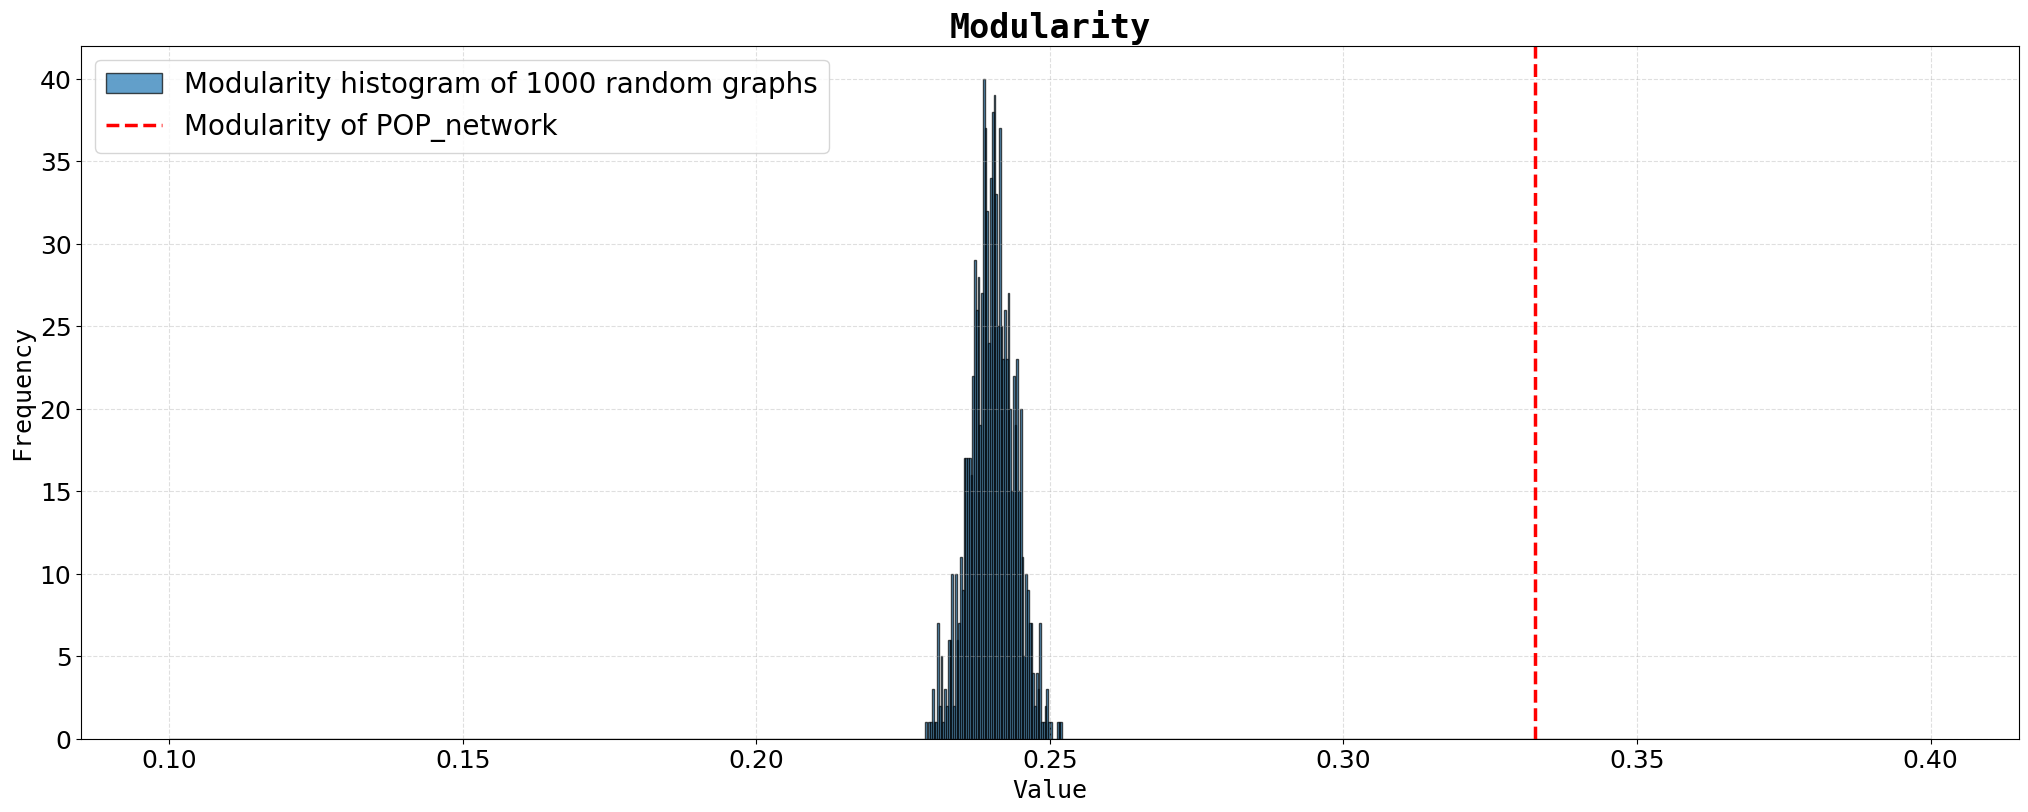

In [17]:
num_bins = 1000

plt.figure(figsize=(25,9))
plt.hist(mods, bins=num_bins, range=(0.1,0.4),edgecolor='black', alpha=0.7, label="Modularity histogram of 1000 random graphs")
plt.xlabel('Value',  fontname="monospace", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.axvline(np.mean(mods), color="black", linestyle='--', label=r'$\mu$ modularity of 1000 random graphs', linewidth=2.5)
plt.axvline(0.3326191182794552, color="red", linestyle="--", label="Modularity of POP_network", linewidth=2.5)
plt.ylabel('Frequency',  fontname="monospace", fontsize=18)
plt.title('Modularity', fontsize=24, fontname="monospace", fontweight='bold') #plt.title("Accuracy of Entropy and Random", fontsize=16, fontname="monospace", fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=20)
plt.show()

### RAP

In [18]:
with open("1000random_networks_POP.pkl", "rb") as f: 
   rnd_networks = pickle.load(f)
mods = []

for g in rnd_networks: 
    communities = community_louvain.best_partition(g)
    modularity = community_louvain.modularity(communities, g)
    mods.append(modularity)

In [19]:
mean = np.mean(mods)
std = np.std(mods)
print(f"Mean: {mean}, Std: {std}")

Mean: 0.2401458732291661, Std: 0.003735480315077647


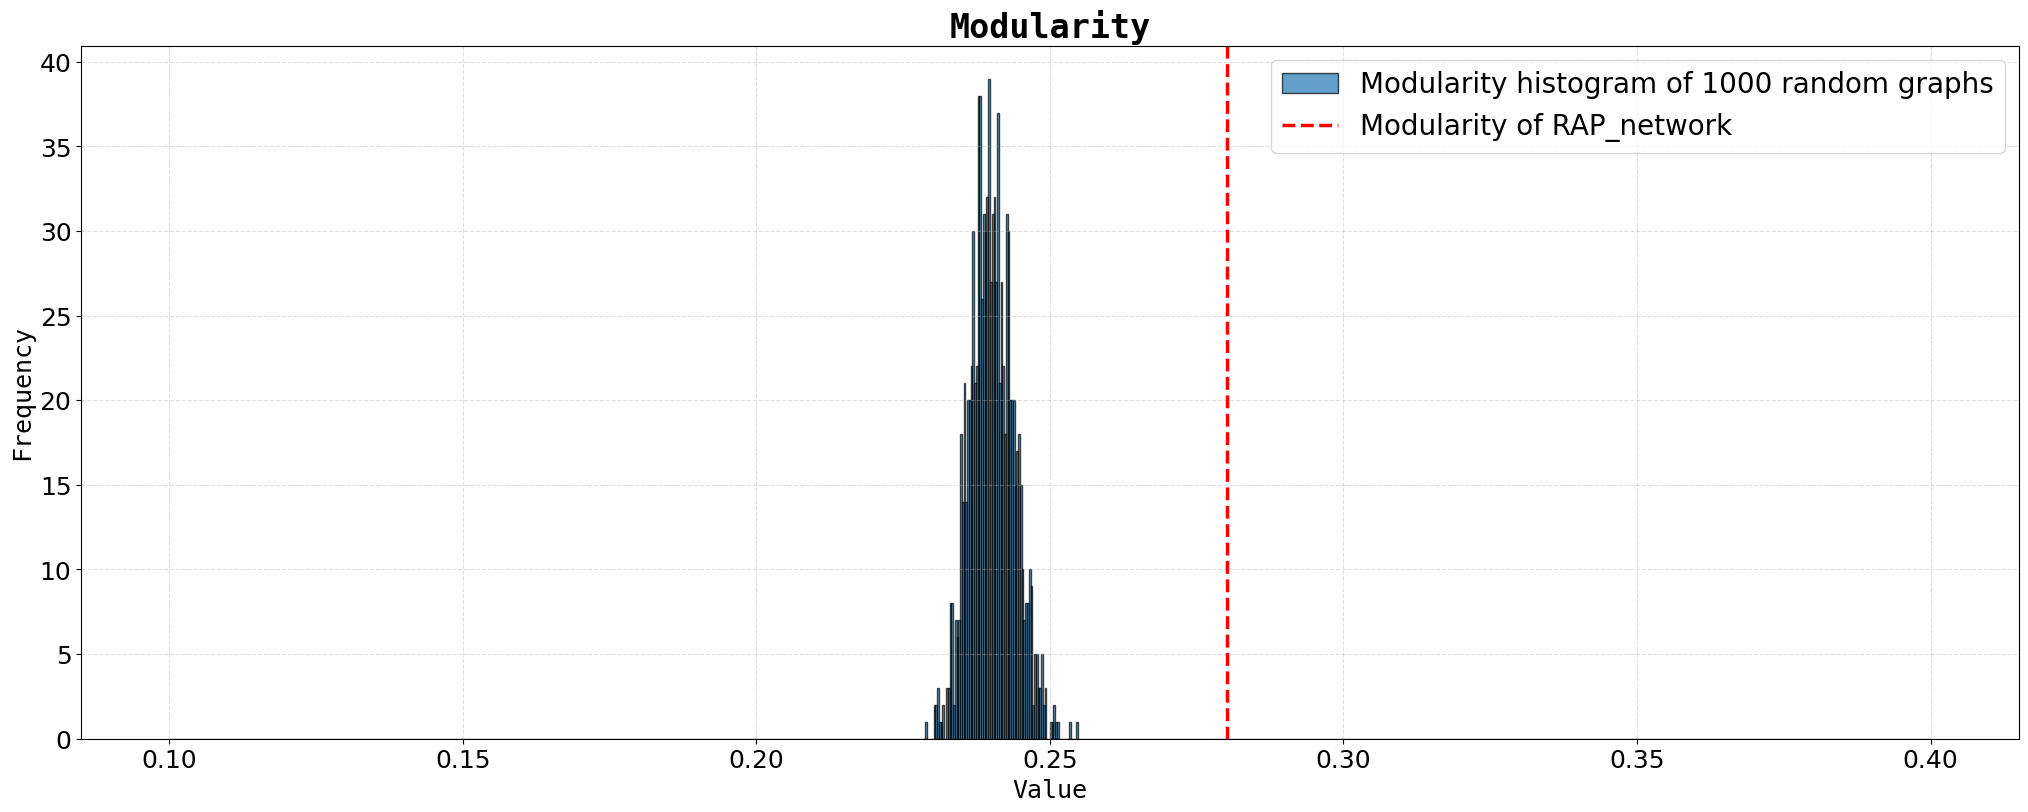

In [21]:
num_bins = 1000

plt.figure(figsize=(25,9))
plt.hist(mods, bins=num_bins, range=(0.1,0.4),edgecolor='black', alpha=0.7, label="Modularity histogram of 1000 random graphs")
plt.xlabel('Value',  fontname="monospace", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.axvline(np.mean(mods), color="black", linestyle='--', label=r'$\mu$ modularity of 1000 random graphs', linewidth=2.5)
plt.axvline(0.280116861705991, color="red", linestyle="--", label="Modularity of RAP_network", linewidth=2.5)
plt.ylabel('Frequency',  fontname="monospace", fontsize=18)
plt.title('Modularity', fontsize=24, fontname="monospace", fontweight='bold') #plt.title("Accuracy of Entropy and Random", fontsize=16, fontname="monospace", fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=20)
plt.show()

In [ ]:
colors = ['#e57468', '#68e574', '#7468e5', '#e5d068', '#68d0e5']
netwulf_plot_communities(G_rap, communities, port=9981, color_palette=colors, path="Pop_network.pdf")

# FOR FIXING POP AND RAP LYRICS

In [201]:
with open("Missing1.pkl", "rb") as f: 
    df1 = pickle.load(f)
new = [res for res in df1[0].tolist() if res != None]
df2 = pd.DataFrame(new)

In [202]:
df2

,name,lyrics
0,Takeoff,[88 ContributorsCasper LyricsOriginally teased...
1,Black Eyed Peas,[192 ContributorsTranslationsPortuguêsFrançais...
2,Migos,[636 ContributorsTranslationsPortuguêsРусскийI...
3,Pusha T,[498 ContributorsTranslationsPortuguêsРусскийE...
4,Janusz Walczuk,[31 ContributorsJanusz Walczuk Lyrics[Zwrotka ...
...,...,...
127,N'Samble,[]
128,Lo Blanquito,[4 ContributorsTelacuti Lyrics“Telacuti” habla...
129,Steve Lacy,[108 ContributorsTranslationsРусскийDark Red L...
130,Fazura,[1 ContributorCinderella Lyrics[Verse 1: Fatta...


In [179]:
with open("Missing2.pkl", "rb") as f: 
    df = pickle.load(f)
df[df["name"] == "Omar Rudberg"]["lyrics"].item()

['7 ContributorsTranslationsEnglishPortuguêsSimon’s Song (From the Netflix Series Young Royals) LyricsForna dagar, flydda år\nDe säger tid läker alla sår\nDet gjorde ont, jag tappa bort mig själv\nJag var lost, innan jag hittade hem\nDet vi hade och de vi var\nKan aldrig glömma allt som var bra\nOm ni kräver mig på svar\nLever alla minnen kvar\n\nVi har prövats, vi fick slåss\nMen det vi var kan ingen ta från oss\nGår skilda vägar när det är slut\nNåt som jag kommer minnas livet ut\n\nDet vi hade och de vi var\nKan aldrig glömma allt som var bra\nOm frågan har ett svar\nLever Hillerska alltid kvar\n\nOm du såg mig här i dag\nSåg hur längtan gör mig svag\nOch de minnen som finns kvar inom mig\nJa, om jag såg dig här i dag\nJag skulle fråga hur det var\nOch om minnena finns kvar inom dig\n\n\nVi har prövats, vi fick slåss\nMen det vi var kan ingen ta från oss\nGår skilda vägar när det är slut\nNåt jag kommer minnas livet ut',
 "13 ContributorsIt Takes a Fool to Remain Sane Lyrics[Verse 1

In [223]:
with open("rap_df.pkl", "rb") as f: 
    rap_df = pickle.load(f)

In [233]:
rap_df[rap_df["lyrics"].isna()]

,spotify_id,name,followers,popularity,genres,chart_hits,lyrics
37,1xr2G8Hlx4QWmT9HaUbmoO,Young Stoner Life,90775.0,65,"[hip hop, rap, southern hip hop, trap]","['us (10)', 'gb (3)', 'au (1)', 'at (2)', 'be ...",NaN
97,1yxSLGMDHlW21z4YXirZDS,Black Eyed Peas,6881366.0,80,"[dance pop, pop, pop rap]","['us (3)', 'gb (2)', 'ar (3)', 'au (3)', 'at (...",NaN
98,4VMYDCV2IEDYJArk749S6m,Daddy Yankee,29446452.0,87,"[latin hip hop, reggaeton, trap latino]","['us (3)', 'gb (1)', 'ar (32)', 'au (1)', 'at ...",NaN
129,2KpK4apOMD6evPHoPggSVF,LEX,92800.0,55,"[j-rap, japanese trap]",['jp (1)'],NaN
152,0ONHkAv9pCAFxb0zJwDNTy,Pusha T,2551259.0,73,"[hip hop, pop rap, rap, southern hip hop, trap...","['us (14)', 'gb (3)', 'au (1)', 'bg (5)', 'ca ...",NaN
153,699OTQXzgjhIYAHMy9RyPD,Playboi Carti,6914690.0,82,"[atl hip hop, plugg, pluggnb, rap]","['us (26)', 'gb (2)', 'au (3)', 'at (1)', 'be ...",NaN
158,0YinUQ50QDB7ZxSCLyQ40k,Mustard,992953.0,72,"[cali rap, hip hop, pop, pop rap, rap, souther...","['us (8)', 'gb (3)', 'au (4)', 'at (1)', 'be (...",NaN
161,2Mu5NfyYm8n5iTomuKAEHl,Ms. Lauryn Hill,2246672.0,71,"[alternative r&b, conscious hip hop, neo soul,...","['gb (1)', 'ie (1)']",NaN
323,0iEtIxbK0KxaSlF7G42ZOp,Metro Boomin,3030563.0,79,"[hip hop, rap, southern hip hop, trap]","['us (14)', 'gb (6)', 'au (2)', 'at (1)', 'be ...",NaN
396,7dGJo4pcD2V6oG8kP0tJRR,Eminem,59184634.0,90,"[detroit hip hop, hip hop, rap]","['us (78)', 'gb (72)', 'ar (7)', 'au (64)', 'a...",NaN


In [232]:
for idx, name in rap_df[rap_df["name"].isin(df["name"].tolist())]["name"].items(): 
    try: 
        rap_df.at[idx, 'lyrics'] = df[df["name"] == name]["lyrics"].item()
    except:
        print(idx, name)

In [218]:
df2[df2["name"] == "Cardi B"]["lyrics"].item()

['645 ContributorsTranslationsTürkçeEspañolСрпскиРусскийRomânăPortuguêsDeutschFrançaisNederlandsالعربية中文ΕλληνικάPolskiWAP Lyrics“WAP” (Wet-Ass Pussy) is Cardi B’s fourth number 1 hit on Billboard, her first release of 2020, and her first single since 2019’s “Press.” It is expected to appear on her upcoming second studio album and… Read More\xa0[Intro: Cardi B, Al "T" McLaran & Megan Thee Stallion]\nWhores in this house\nThere\'s some whores in this house\nThere\'s some whores in this house\nThere\'s some\u2005whores\u2005in this house\u2005(Hol\' up)\nI said certified freak, seven\u2005days a week\nWet-ass pussy, make that pullout game weak, woo (Ah)\n\n[Chorus: Cardi B]\nYeah, yeah, yeah, yeah\nYeah, you fuckin\' with some wet-ass pussy\nBring a bucket and a mop for this wet-ass pussy\nGive me everything you got for this wet-ass pussy\n\n[Verse 1: Cardi B & Megan Thee Stallion]\nBeat it up, nigga, catch a charge\nExtra large and extra hard\nPut this pussy right in your face\nSwipe yo

In [221]:
pop_df[pop_df["lyrics"].isna()]

,spotify_id,name,followers,popularity,genres,chart_hits,lyrics
62,0tzSBCPJZmHTdOA3ZV2mN3,CL,1064466.0,60,[k-pop],"['bg (1)', 'hk (1)', 'id (2)', 'my (4)', 'ph (...",NaN
64,1n9MS5jDsiVS3x3ArntcnW,Lin Hsin Yi,48805.0,35,"[mandopop, taiwan pop]",['tw (4)'],NaN
94,2h93pZq0e7k5yf4dywlkpM,Frank Ocean,9951370.0,83,"[hip hop, lgbtq+ hip hop, neo soul, pop]","['us (17)', 'gb (10)', 'au (15)', 'at (1)', 'b...",NaN
117,19ra5tSw0tWufvUp8GotLo,George Michael,3898805.0,71,[dance pop],"['gb (3)', 'ar (1)', 'au (2)', 'be (3)', 'bg (...",NaN
182,3w8fdvgPp2aKgy125EBgVg,玖壹壹,175195.0,48,"[mandopop, taiwan hip hop, taiwan pop]",['tw (12)'],NaN
...,...,...,...,...,...,...,...
4257,04XdCDDrPnnqidaVBTOQjt,Hernan y La Champion's Liga,96920.0,54,"[cumbia pop, cumbia villera]",NaN,NaN
4259,2OaHYHb2XcFPvqL3VsyPzU,Rico Nasty,949031.0,67,"[alternative r&b, dance pop, dmv rap, escape r...",NaN,NaN
4272,1wiBLzTI7z9RUwEpNPdFT6,Mase,679487.0,65,"[gangster rap, hardcore hip hop, harlem hip ho...",NaN,NaN
4331,1oKdM70mJD8VvDOTKeS8t1,Emily Warren,57320.0,56,[nyc pop],NaN,NaN


In [234]:
with open("rap_dfV2.pkl", "wb") as f: 
    pickle.dump(rap_df, f)